In [510]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import os
from os import listdir
from os.path import isfile, join
import skfda
from skfda.representation.interpolation import SplineInterpolation
from skfda.exploratory.visualization import Boxplot
import datetime as dt
from numpy.polynomial.polynomial import polyfit
from sklearn.metrics import mean_squared_error

In [511]:
# Variabili globali

path = 'pala_ok/acquisizione 22-05-2023/'

In [512]:
allacqui_temp = []

allacqui_input = []

# Andiamo a prendere tutti i path dei vari file

path_acquisizioni = [f for f in listdir(path) if isfile(join(path, f))]


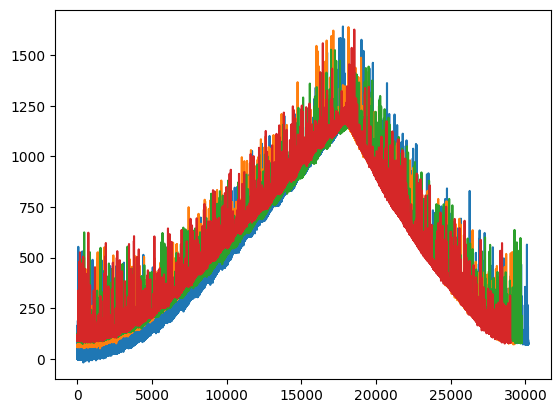

In [513]:
# Abbiamo usato il range siccome i csv hanno separatori diversi

for a,b in zip(path_acquisizioni,range(0,len(path_acquisizioni))):
    if("input" in a):
        allacqui_input.append(pd.read_csv(path+a,sep='\t'))
    else:
        allacqui_temp.append(pd.read_csv(path+a,sep='\t').drop_duplicates(subset=['time'],keep='last',ignore_index=True))

allacqui = []
for a,b in zip(allacqui_temp,range(len(allacqui_temp))):
    if(b % 3 ==0):
        allacqui.append([])
        a['Voltage'] = (10 - a['Voltage'])*500
        plt.plot(a['Voltage'])
    allacqui[-1].append(a)



In [514]:
print(len(allacqui_input))
print(len(allacqui))
print(len(allacqui[0]))
#print(allacqui)

4
4
3


In [515]:
# Check delle dimensioni

print(type(allacqui[0][0][:10].mean()))

for a in range(len(allacqui[0])):
    print(allacqui[0][a].shape)

<class 'pandas.core.series.Series'>
(30192, 2)
(29327, 2)
(29357, 2)


In [516]:
def moving_average(a, n=10) :
    ret = np.cumsum(a)
    ret[n:] = ret[n:] - ret[:-n]
    return ret[n - 1:] / n

In [517]:
#media mobile
allacqui[0][0] = allacqui[0][0].rolling(10,min_periods = 1,center=False).mean()

In [518]:
print(type(allacqui[0][0]))
print(allacqui[0][0].head(10))

<class 'pandas.core.frame.DataFrame'>
           time   Voltage
0  1.684771e+15  0.378698
1  1.684771e+15  0.540242
2  1.684771e+15  1.024871
3  1.684771e+15  1.146029
4  1.684771e+15  1.186415
5  1.684771e+15  1.078719
6  1.684771e+15  0.909483
7  1.684771e+15  0.863328
8  1.684771e+15  0.845379
9  1.684771e+15  0.814865


In [519]:
# Andiamo a lavorare sui dati di national instrument, ne riduciamo le dimensioni usando la media

data_matrix = allacqui[0][2]['volts']
grid_points = allacqui[0][2]['time']

fd_manu = skfda.FDataGrid(
    data_matrix=data_matrix,
    grid_points=grid_points,
    dataset_name="Datagrid di esempio",
    argument_names=('time',),
    coordinate_names=('values',),
    interpolation=SplineInterpolation(interpolation_order=3)
)

c:\Users\Leo\.conda\envs\manu2\lib\site-packages\skfda\exploratory\depth\multivariate.py:276: RuntimeWarning: invalid value encountered in divide
  return (  # type: ignore[no-any-return]


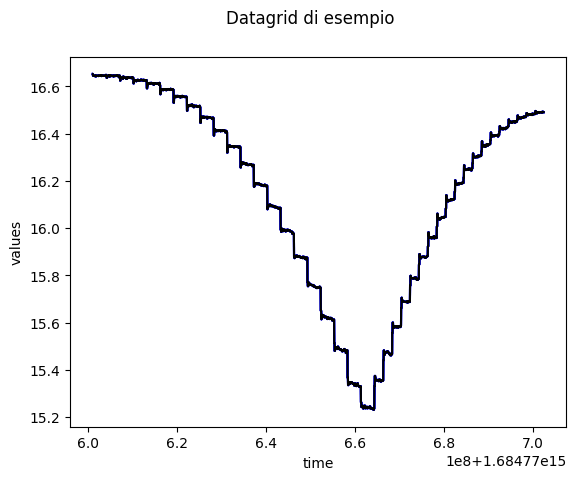

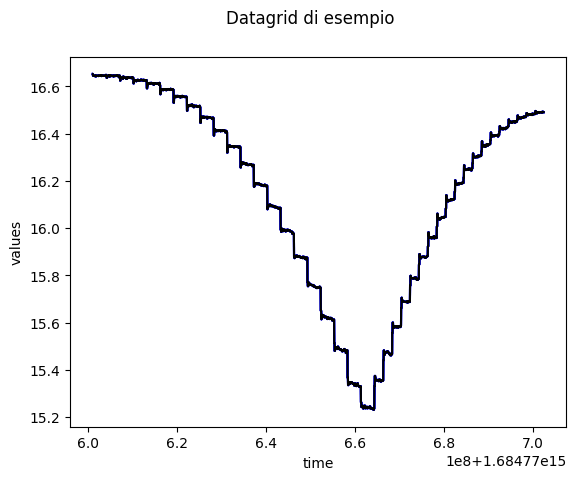

In [520]:
fdBoxplot = Boxplot(fd_manu)
fdBoxplot.show_full_outliers = True
fdBoxplot.plot()

In [521]:
import numpy as np
def makepwm(d):
    off_setList = len([d-x for x in b['time'] if (d - x > 0)])
    if(off_setList == 0):
       return 0
    else:
      return b['pwm_percent'][off_setList-1]
makepwmElem = np.vectorize(makepwm)

In [522]:
all_PWMoutput = []

for acquisizione,b in zip(allacqui,allacqui_input): 
    
    all_PWMoutput.append([])
    for timestamp in acquisizione:
        all_PWMoutput[-1].append([])
        all_PWMoutput[-1][-1] = makepwmElem(timestamp['time'])
        


In [523]:
print(len(all_PWMoutput))

print(all_PWMoutput[0][0][0])

4
2


In [524]:
print(all_PWMoutput)
print(len(all_PWMoutput))
print(len(all_PWMoutput[0]))

for pwmoutput,acqui in zip(all_PWMoutput,allacqui):
    for a,b in zip(pwmoutput,acqui):

        print(len(a))
        print(type(a))
        print(len(b))
        print(type(b))
        print(' Questi sono i valori di a e b')

    

[[array([2, 2, 2, ..., 5, 5, 5], dtype=int64), array([2, 2, 2, ..., 5, 5, 5], dtype=int64), array([2, 2, 2, ..., 5, 5, 5], dtype=int64)], [array([2, 2, 2, ..., 5, 5, 5], dtype=int64), array([2, 2, 2, ..., 5, 5, 5], dtype=int64), array([2, 2, 2, ..., 5, 5, 5], dtype=int64)], [array([2, 2, 2, ..., 5, 5, 5], dtype=int64), array([2, 2, 2, ..., 5, 5, 5], dtype=int64), array([2, 2, 2, ..., 5, 5, 5], dtype=int64)], [array([2, 2, 2, ..., 5, 5, 5], dtype=int64), array([2, 2, 2, ..., 5, 5, 5], dtype=int64), array([2, 2, 2, ..., 5, 5, 5], dtype=int64)]]
4
3
30192
<class 'numpy.ndarray'>
30192
<class 'pandas.core.frame.DataFrame'>
 Questi sono i valori di a e b
29327
<class 'numpy.ndarray'>
29327
<class 'pandas.core.frame.DataFrame'>
 Questi sono i valori di a e b
29357
<class 'numpy.ndarray'>
29357
<class 'pandas.core.frame.DataFrame'>
 Questi sono i valori di a e b
29272
<class 'numpy.ndarray'>
29272
<class 'pandas.core.frame.DataFrame'>
 Questi sono i valori di a e b
29000
<class 'numpy.ndarray

In [525]:
# Andiamo a definire un datagrid per ogni dataframe con NUOVE SPECIFICHE

all_data_grid = []
datasetTitles = ['National Instrument','RPM','Battery']
for pwmoutput,acqui in zip(all_PWMoutput,allacqui):
    all_data_grid.append([])
    for a,b,i in zip(acqui,pwmoutput,range(len(acqui))):        
        data_matrix = np.stack((np.array(a[a.columns.values[1]]), np.array(b)))
        grid_points = a[a.columns.values[0]]

        all_data_grid[-1].append(skfda.FDataGrid(
        data_matrix=data_matrix,
        grid_points=grid_points,
        dataset_name=datasetTitles[i],
        argument_names=(a.columns.values[0],),
        coordinate_names=(a.columns.values[1],),
        interpolation=SplineInterpolation(interpolation_order=1)
        ))
    

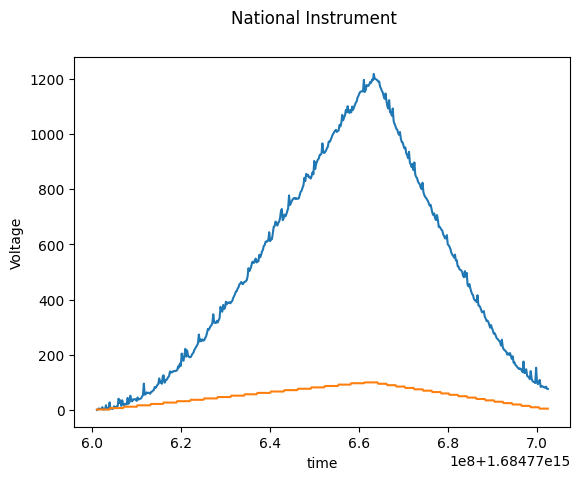

In [526]:
all_data_grid[0][0].plot()
print()

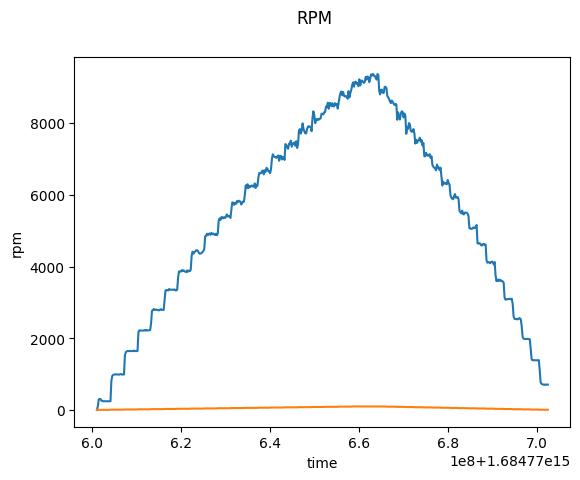

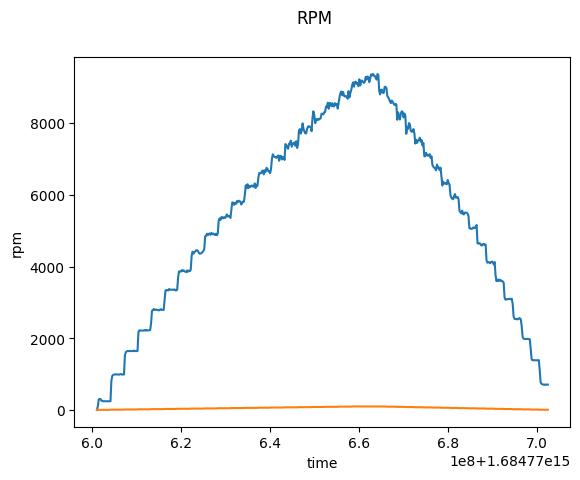

In [527]:
all_data_grid[0][1].plot()

1222.0979224017356


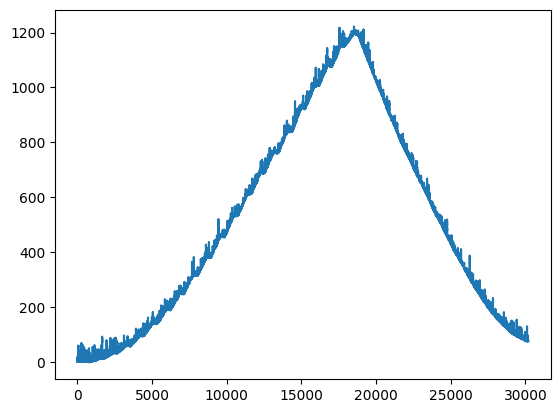

In [528]:
print(all_data_grid[0][0].data_matrix[0].max())
plt.plot(all_data_grid[0][0].data_matrix[0])


In [529]:
#Fitting for National Instrument
pol_maxGrade = 4 # afte the grade 5 it become glitchy
fit_result = []
for acquisizione in all_data_grid:
    fit_result.append([])
    for dataset in acquisizione:

        fit_result[-1].append([])
        for i in range(pol_maxGrade):
            fit_result[-1][-1].append(polyfit(dataset.data_matrix[1][:,0],dataset.data_matrix[0],deg=i+1))


4
3
4


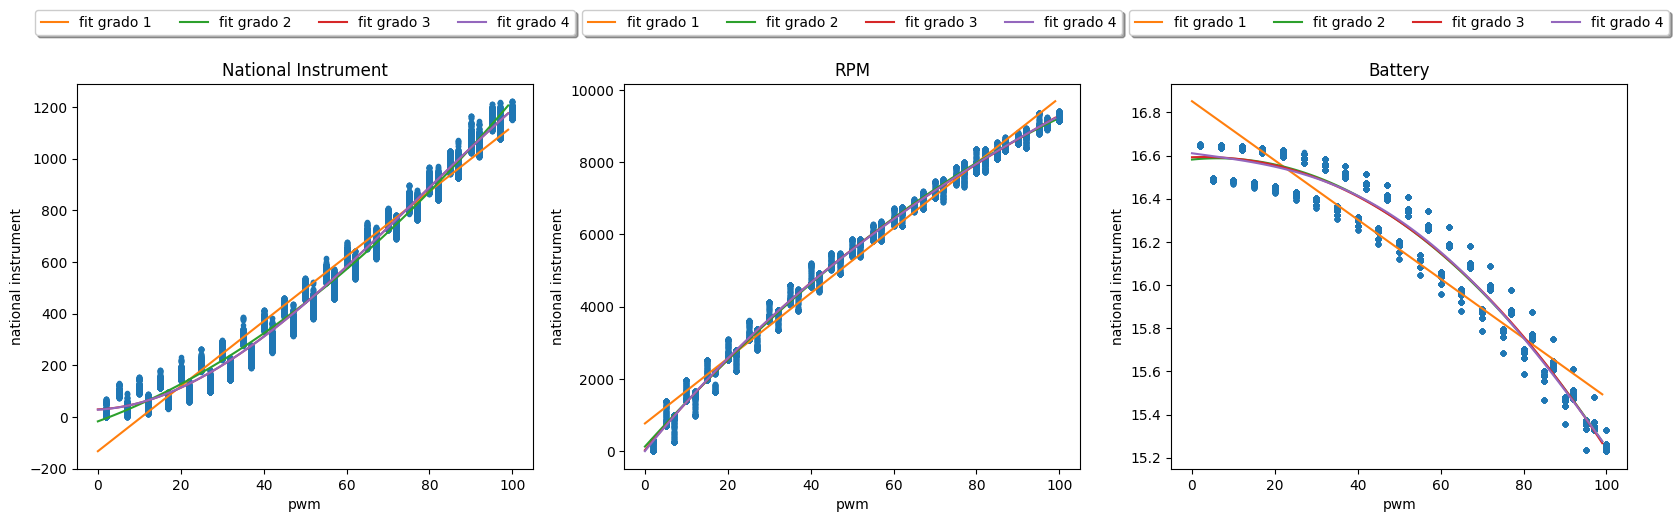

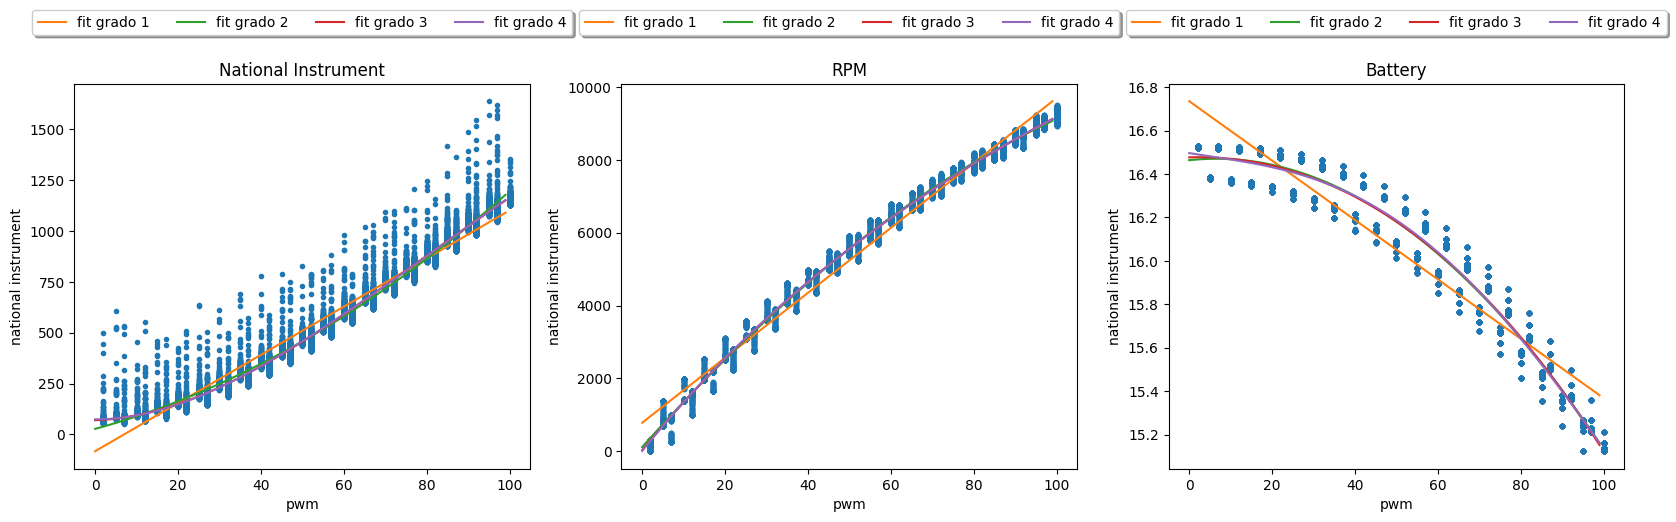

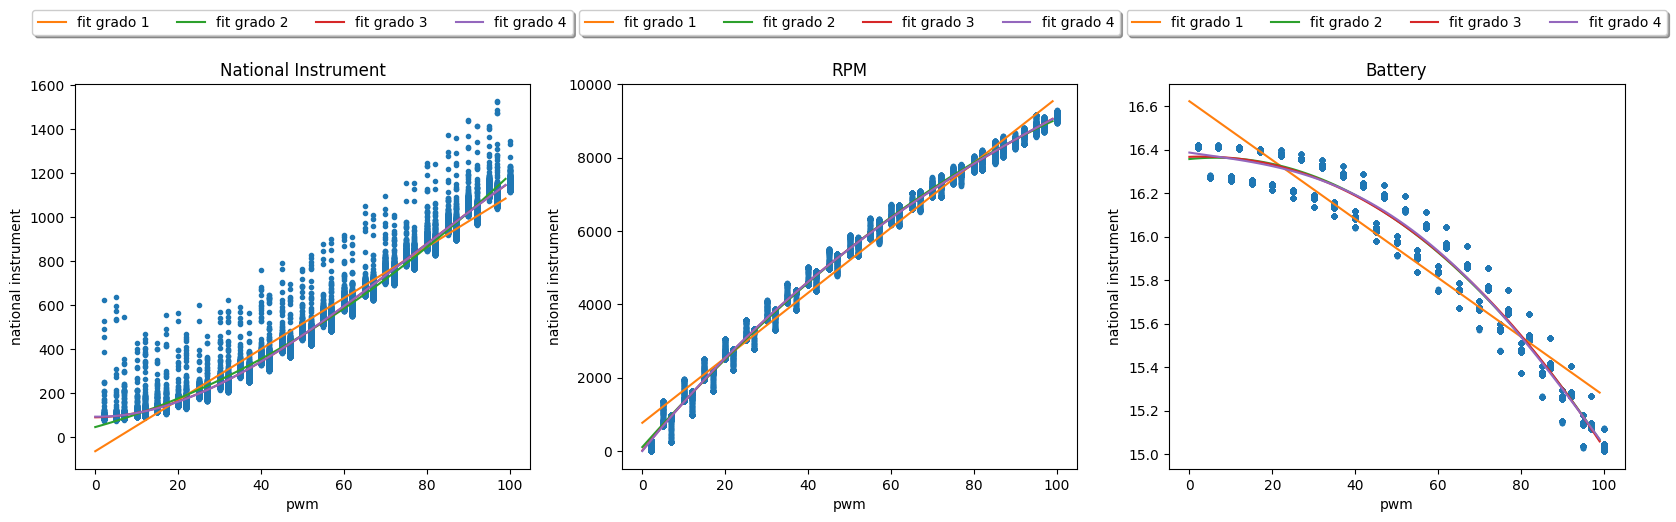

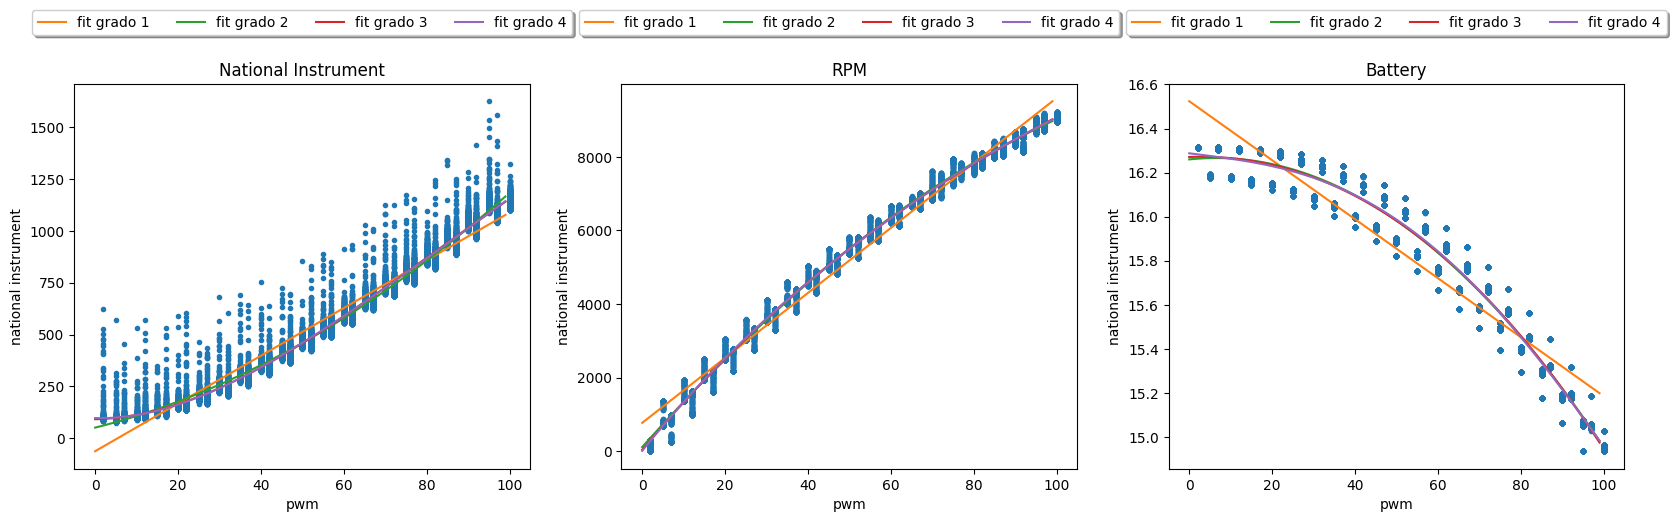

In [545]:

for acquisizione,fit_set in zip(all_data_grid,fit_result):
    fig, axs = plt.subplots(nrows = 1, ncols = 3)
    fig.set_size_inches(h=5,w=20)
    
    linex = np.arange(0,100,1)
    for dataset,dataset_fit,index in zip(acquisizione,fit_set,range(len(acquisizione))):
        axs[index].plot(dataset.data_matrix[1][:,0],dataset.data_matrix[0],'.')
        axs[index].set_xlabel('pwm')
        axs[index].set_ylabel('national instrument')
        for fit,indice in zip(dataset_fit,range(pol_maxGrade)):
            plotRes = 0
            for i in range(len(fit)):
                plotRes += fit[i]*linex**i  
            axs[index].plot(linex, plotRes,'-',label='fit grado '+str(indice+1))
        axs[index].set_title(datasetTitles[index])
        axs[index].legend(loc='upper center', bbox_to_anchor=(0.5, 1.21),ncol=4, fancybox=True, shadow=True)

In [ ]:
# Andiamo a calcolare il mean squared error

y_pred = all_data_grid[0].data_matrix[0]
for fit,g in zip(fit_result,range(len(fit_result))):
    y_true = 0
    for i in range(len(fit)):
        y_true += fit[i]*all_data_grid[0].data_matrix[1][:,0]**i
    print('grado' + str(g+1))
    print(mean_squared_error(y_true, y_pred[:,0]))

grado1
4419.540569368194
grado2
2003.196254526822
grado3
1750.877465908583
grado4
1750.770794982276
